When determining the required venting for above ground storage tanks it is typical to calculate normal and emergency vent rates using standards such as API 2000, which gives the venting as an equivalent flow rate of air at standard state. Most off-the-shelf vents are sized in terms of pressure drop and SCFH through it, so after calculating the required venting one can simply buy a vent with the needed characteristics.

::: {#fig-1}
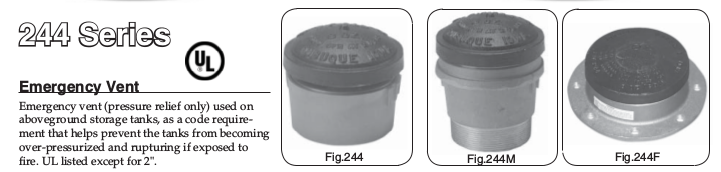\

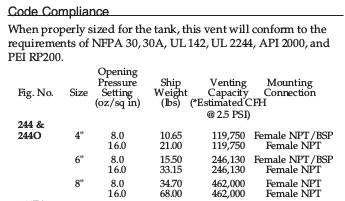\

An example emergency vent from Morrison brothers
:::

It's not uncommon, though, for tanks to have goose-neck vents constructed from piping. This is fairly normal for tanks holding water, or other nonvolatile substances, where the tank is open to atmosphere and there are no dangerous vapours that need to be managed. The goose-neck itself is merely to keep rain, and wildlife, out of the tank.

Sizing the goose-neck to match the required venting involves performing some simple compressible flow calculations, which is fairly straightforward to set up in a generalized way such that, beyond this motivating example, it can be extended to lots of other problems. Though it isn't at all uncommon, in this particular case, for the flow calculations to be done assuming an incompressible fluid as, over the length of the goose-neck, the pressure drop is typically slight and the compressibility of the gas (air usually) is not important.

With that in mind, I am going to work through the problem in stages of escalating complexity, very likely the most complicated (fanno flow) is overkill for this specific example but it's worth putting it all down as the same tools can be used for compressible flow calculations through many piping situations.

## The Scenario

Suppose an atmospheric storage tank with a normal venting requirement, as calculated from API 2000 or the like, of 200&times;10³ SCFH and a max pressure of 1 psig. We wish to design a goose-neck vent that can handle that level of venting. Suppose that the goose-neck design we have in mind is a vertical length of pipe extending up from the tank roof, two 90° bends, and an exit covered with a mesh screen (to keep birds from nesting in it, yes this is a thing). The goose-neck is a constant diameter of pipe throughout.

For notation, the flow begins at the pipe entrance (1) and ends at the exit (2).

::: {#fig-2}
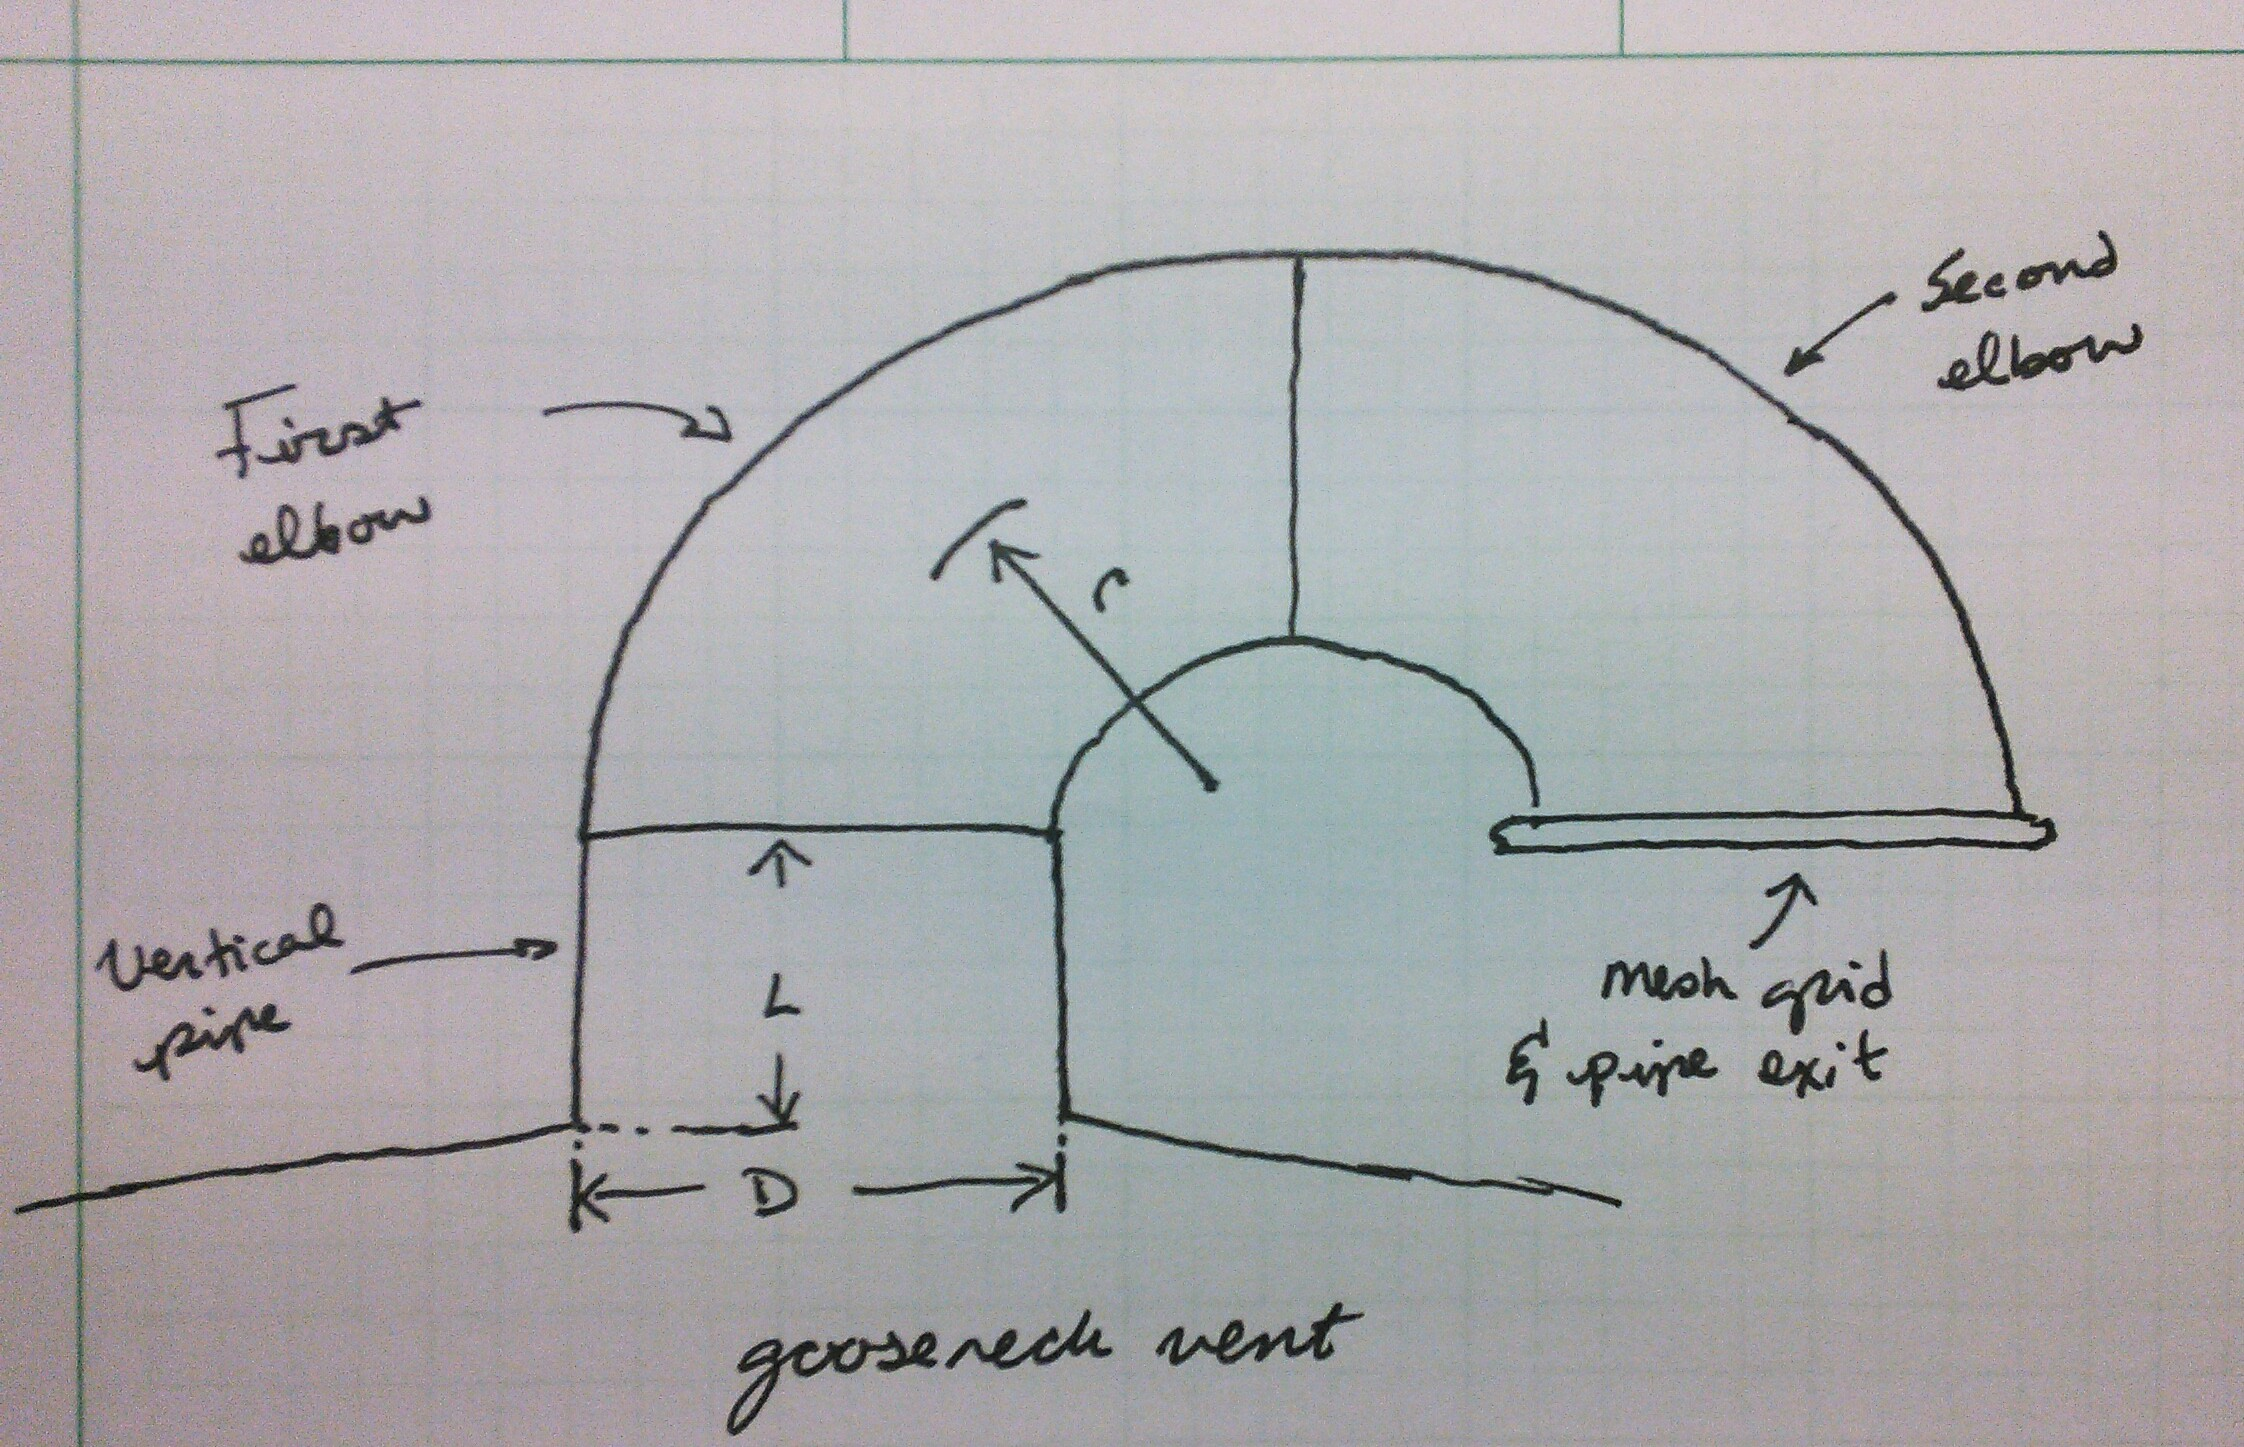\

A sketch of the goose neck vent.
:::

For the pipe bends the bend radius to diameter ratio needs to be specified, I'm going to suppose $r/D = 1.5$. Another important parameter is the pipe roughness, $\epsilon$, which for commercial steel is $\epsilon = 0.0457 \mathrm{mm}$[@tilton-2007 page 6-10]. At this point I could specify a length for the straight section of pipe, a fixed height above the tank roof that is independent of the final chosen diameter of the piping, or I could fix a design and scale the whole vent up and down as required. For simplicity I am going to assume 3ft of piping.

At this point I am going to set up the equations with no knowledge of what the final pipe diameter $D$ will be, then numerically solve for the minimum diameter that meets the requirements. The actual diameter will be the next largest NPS size pipe.

In [1]:
using Unitful: @u_str, uconvert, ustrip, upreferred

# Setting up some convenient unit conversions
SCFH = uconvert(u"m^3/s", 1u"ft^3/hr")
psi = uconvert(u"Pa", 1u"psi")
ft = uconvert(u"m", 1u"ft")
inch = uconvert(u"m", 1u"inch")
mm = uconvert(u"m", 1u"mm")

# Given in the scenario, now converted to SI
Q = 200e3SCFH
pₐ = 14.696psi
pₘₐₓ = 1psi + pₐ
L = 3ft
ϵ = 0.0457mm;

I am assuming, for simplicity, that ambient conditions are standard conditions.

In [2]:
# Universal gas constant to more digits than are at all necessary
R = 8.31446261815324u"Pa*m^3/mol/K"

# Standard conditions, 15°C 
Tₐ = 288.15u"K"

# Some useful physical properties of air
Mw = 0.02896u"kg/mol"  # Molar weight of air, from Perry's
k = 1.4                # Ratio of heat capacities, Cp/Cv, ideal gas

# density of air, ideal gas law, kg/m^3
ρ(p, T) = (p * Mw)/(R * T)

# viscosity of air, from Perry's
μ(T) = 1u"Pa*s"*(1.425e-6*ustrip(u"K",T)^0.5039)/(1 + 108.3/ustrip(u"K",T));

### Frictional head loss

Regardless of the method of performing the compressible flow calculations, the frictional head loss in the piping needs to be accounted for. I am using the K factor method as it is convenient and K factors are tabulated for most everything in references such as Crane's TP-410. One thing to be very careful with is the difference between the Darcy and Fanning friction factors. I am using Crane's where everything is in terms of the Darcy friction factor, which is 4&times; the Fanning friction factor, but Perry's defaults to the Fanning friction factor.

From Crane's I have the following K factors for each piece of the goose-neck[@crane-2013 page A-30]

+ Entrance - $K_1 = 0.5$
+ Vertical Pipe - $K_2 = f \frac{L}{D}$
+ First 90° bend - $K_3 = 14 f_T$
+ Second 90° bend - $K_4 = 14 f_T$
+ Mesh screen - $K_5 = f_T$
+ Exit to atmosphere - $K_6 = 1.0$


Where $f$ is the Darcy friction factor, $f_T$ is the turbulent friction factor. I am assuming the entrance to the vent is sharp edged, and the K factors for the bends are for bends with $r/D = 1.5$.

For some notational convenience I am going to define the relative roughness $\kappa = { \epsilon \over D }$ and the reduced length $l = {L \over D}$ so that, along with the Reynolds number $Re$, the K factors are in terms of dimensionless numbers only.

The Darcy friction factor generally depends on which regime the flow is in, laminar, transitional, or turbulent. Since I don't want to be referring to a Moody diagram I want to use a single equation that operates over a wide range of Reynolds numbers and potentially in laminar and transitional flow regimes since I don't know *a priori* what the flow in the vent will be. There are equations like the Serghide correlation or Churchill correlation that attempt to fit a Moody diagram but in a more convenient to use manner.

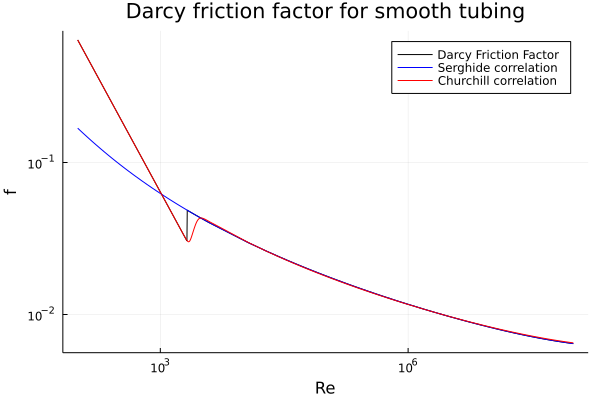

In [3]:
#| echo: false
#| label: fig-3
#| fig-cap: "A Moody diagram with the Serghide correlation and Churchill correlation overlaid."

using Plots: plot, plot!

let

using Roots: find_zero

κₚₗₜ = 0.000001 # Smooth tubes

function Darcyf(κ, Re)
    if Re <= 2100
        # laminar
        fD = 64/Re
    elseif Re >= 4000
        # turbulent
        f₀ = 64/Re
        fD = find_zero( f -> f^-0.5 + 2*log10( (κ/3.7) + (2.51/(Re*√(f))) ), f₀)
    else
        # transitional
        fₗ = 64/Re
        fₜ = find_zero( f -> f^-0.5 + 2*log10( (κ/3.7) + (2.51/(Re*√(f))) ), fₗ)
        fD = max(fₗ,fₜ)
    end
    
    return fD
end

function serghide(κ, Re)
    A = -2 * log10( (κ/3.7) + (12/Re) )
    B = -2 * log10( (κ/3.7) + (2.51*A/Re) )
    C = -2 * log10( (κ/3.7) + (2.51*B/Re) )
    return (A - ((B-A)^2 / (C-2*B+A)))^-2
end

function churchill(κ, Re)
    A = (2.457 * log(1/((7/Re)^0.9 + 0.27*κ)))^16
    B = (37530/Re)^16
    return 4 * 2*((8/Re)^12 + 1/(A+B)^(3/2))^(1/12)
end

plot(Re -> Darcyf(κₚₗₜ, Re), 100, 2100, color=:black, lab = false)
plot!(Re -> Darcyf(κₚₗₜ, Re), 2100, 4000, color=:black, lab = false)
plot!(Re -> Darcyf(κₚₗₜ, Re), 4000, 1e8, color=:black, lab="Darcy Friction Factor")
plot!(Re -> serghide(κₚₗₜ, Re), 100, 2100, color=:blue, lab = false)
plot!(Re -> serghide(κₚₗₜ, Re), 2100, 4000, color=:blue, lab = false)
plot!(Re -> serghide(κₚₗₜ, Re), 4000, 1e8, color=:blue, lab="Serghide correlation")
plot!(Re -> churchill(κₚₗₜ, Re), 100, 2100, color=:red, lab = false)
plot!(Re -> churchill(κₚₗₜ, Re), 2100, 4000, color=:red, lab = false)
plot!(Re -> churchill(κₚₗₜ, Re), 4000, 1e8, color=:red, lab="Churchill correlation")
plot!(title = "Darcy friction factor for smooth tubing", xaxis=:log, yaxis=:log, xlabel = "Re", ylabel="f", leg = :topright)

end

The black line conservatively takes the max of either the laminar or turbulent friction factor in the transitional region $2100 \le Re \le 4000$. The Churchill correlation fits the general curve well for both the turbulent and laminar region, and provides reasonable values in the transitional region.

The Churchill correlation is[@tilton-2007 page 6-11. The equation here is given in terms of the darcy friction factor.]


$$ f = 8 \left( \left( \frac{8}{Re} \right)^{12} + { 1 \over {\left( A+B \right)^{3/2} } } \right)^{1/12} $$

$$ A = \left( 2.457 \ln\left( {1 \over {\left( \frac{7}{Re} \right)^{0.9} + 0.27\kappa} } \right) \right)^{16} $$

$$ B = \left( \frac{37530}{Re} \right)^{16} $$

The turbulent friction factor is the friction factor at fully turbulent flow, when *f* is no longer dependent upon the Reynolds number.

$$ f_T = { 0.25 \over { \left( \log \left( \kappa \over 3.7 \right) \right)^2 } } $$

With these defined I can write a function that gives $\sum_j K_j$ for any $\kappa$, *l*, and *Re*


In [4]:
function f(κ, Re)
    A = (2.457 * log(1/((7/Re)^0.9 + 0.27*κ)))^16
    B = (37530/Re)^16
    return 8*((8/Re)^12 + 1/(A+B)^(3/2))^(1/12)
end

fT(κ) = 0.25/log10(κ/3.7)^2

ΣK(κ,l,Re) = 0.5 + f(κ,Re)*l + 14*fT(κ) + 14*fT(κ) + fT(κ) + 1.0;

### The Reynolds number

Since the vent has a constant cross sectional area, the mass velocity, $G$, is constant throughout

$$ G = \frac{4 \dot{m} }{\pi D^2} $$

Where $\dot{m}$ is the mass flow rate in kg/s flowing through the vent, which is
$$\dot{m} = Q_{std} \cdot \rho \left(p_{std}, T_{std} \right) $$
with $Q$ the flow at standard conditions and $\rho$ the density at standard conditions.

*Note* The required vent flow is given in SCFH, this is not temperature or pressure dependent and $\dot{m}$ is a constant. If the flow given was a true volumetric flow rate, then $\dot{m}$ would be a function of temperature and pressure in general. This is one of those things that routinely snags inexperienced engineers as a flow in terms of a standard volume *looks* like a volumetric flow rate, it's in units of volume, but really isn't one since the temperature and pressure are set to standard state by definition.

The Reynolds number in terms of the mass velocity is

$$ Re = \frac{G D}{\mu} $$

The only parameter in the Reynolds number which is not a constant is the viscosity, $\mu$, which is mostly dependent upon temperature and not pressure. So, to a very good first approximation, the Reynolds number is only a function of temperature. Which is very convenient.

In [5]:
# mass flow, recall Q is at standard state so is not a function of 
# temperature or pressure
m = Q*ρ(pₐ, Tₐ)

# mass velocity
G(D) = (4*m)/(π*D^2)

# Reynold's number
# upreferred promotes derived units to combos of base units
# e.g. converts Pa -> kg/m/s^2
Re(D, T) = upreferred(G(D)*D/μ(T));

## Incompressible Flow

For problems, like this vent, where the pressure drop is expected to be small it is not unreasonable to assume the flow is approximately incompressible. This is very often what is done since, typically, it does not require any iterative methods and one can solve for incompressible flow directly. It is also useful to do even if one plans on performing a more complete compressible flow calculation, since this provides something of a sanity check and can be a good place to start compressible flow iterative calculations, i.e. the *initial guess* is from the incompressible case

To check whether or not the incompressible assumption is reasonable, consider the ratio of density inside the tank (at the max allowable pressure) to the density outside the tank, assuming ambient temperature. For an ideal gas this is

$$ { \rho_1 \over \rho_2 } = { {p_1  Mw} \over {R  T_a} } { {R T_a} \over {p_2 Mw} } = \frac{p_1}{p_2} = \frac{p_{max} }{p_a}$$


In [6]:
pₘₐₓ/pₐ

1.0680457267283614

Typically flows are considered incompressible if the density varies by less than ~5-10%, so this example (where the density varies by ~7%) is right in that range. You could justify it either way and it's more a function of how accurate the calculations need to be. Since, ultimately, we are solving for the pipe diameter and choosing the next largest pipe size it's probably fine to use an incompressible flow assumption. If anything the incompressible flow assumption will overestimate the pressure drop and thus lead to an oversized pipe (erring on the side of caution)

The mechanical energy balance for an incompressible fluid is[@tilton-2007 page 6-16]

$$ p_1 - p_2 = \alpha_2 \frac{\rho v_2^2}{2} - \alpha_1 \frac{\rho v_1^2}{2} + \rho g \left( h_2 - h_1 \right) + \sum_j K_j \frac{\rho v^2}{2} $$

With the following simplifications
+ given the assumption of incompressible flow and a vent with a constant cross-sectional area $v_1 = v_2 = v$, 
+ the flow is uniform throughout $\alpha_1 = \alpha_2 = 1.0$ 
+ the contribution due to hydro-static pressure is negligible as the gas density is very small, $\rho g \left( h_2 - h_1 \right) \approx 0$

This becomes 

$$ p_1 - p_2 = \sum_j K_j \frac{\rho v^2}{2} $$

Where the velocity, $v$ is

$$ v = \frac{Q}{A} = { Q \over { \frac{\pi}{4} D^2 } } $$

Which can be solved algebraically for $D$, where $\rho$ is taken at the average pressure. That said it is easier to solve it numerically.

In [7]:
using Roots: find_zero, Brent

v(D) = Q / ((π/4)*D^2)

Dᵢₙ(Dₗ, Dᵤ) = find_zero( 
    (D) -> pₘₐₓ - pₐ - 0.5*ΣK(ϵ/D,L/D,Re(D,Tₐ))*ρ((pₘₐₓ + pₐ)/2, Tₐ)*v(D)^2,
    (Dₗ, Dᵤ), # Lower and upper bracket of the root
    Brent() ) # Solve using Brent's method

D0 = Dᵢₙ(4inch, 12inch)

uconvert(u"inch", D0)

6.497118827423374 inch

At this point one would typically stop for this example, compressible flow calculations are probably unnecessary.

## Compressible Flow

In general compressible flow situations can be very difficult to solve, since the density of the working fluid is a function of the pressure and temperature and the pressure and temperature are varying throughout, which means heat transfer must also be accounted for in some way. There are several key simplifying assumptions that take this from the sort of problem solved with CFD to something actually quite simple. The first is to assume an ideal gas, the second is to examine two *extreme* cases of heat transfer: isothermal flow and adiabatic flow.

At these two extreme cases, the first where heat transfer is instantaneous and the second where it doesn't occur at all, provide bounds on the problem.

### Isothermal Compressible Flow

Isothermal compressible flow of an ideal gas is fairly straight forward. As already mentioned the Reynolds number depends only on temperature, which is constant by definition, so the Reynolds number is a constant. This means the frictional head loss is also constant throughout, and it is a simple matter to calculate the pressure drop.

The assumption that the flow is isothermal is very reasonable in this case. We are assuming normal venting from a tank at thermal equilibrium with it's surroundings, that is that the air flowing through the vent starts and ends in reservoirs of equal temperature. As gases expand the temperature decreases but the pressure drop across the vent is small so this effect should be negligible.

A quick check is to estimate the ratio of temperatures at the start and end of the vent assuming a friction-less adiabatic expansion

$$ p_1^{1-k} T_1^k = p_2^{1-k} T_2^k = \mathrm{const}$$

$$ \frac{T_2}{T_1} = \left( p_1 \over p_2 \right)^{ {1-k} \over k}$$

In [8]:
(pₘₐₓ/pₐ)^((1-k)/k)

0.9813670503935878

So we expect even in the most extreme case the temperature change is ~2%, justifying the assumption that the venting is isothermal.

The isothermal flow of an ideal gas going through a length of piping is[@tilton-2007 page 6-23. This equation also neglects changes in elevation.]


$$ p_{1}^{2} = G^{2} \frac{RT}{Mw} \left[ \sum \limits_{j} K_{j} + 2\ln \frac{p_{1} }{p_{2} } \right] + p_{2}^{2} $$

If we assume the system is at thermal equilibrium with the outside air, then $T = T_a$ and $p_2 = p_a$

The only unknown is *p<sub>1</sub>*, which can be solved for numerically.

In [9]:
pᵢₜ(G,κ,l,Re) = find_zero(
    p -> p^2 - G^2 * (R*Tₐ/Mw) * (ΣK(κ,l,Re) + 2*log(p/pₐ)) - pₐ^2, 
    pₘₐₓ); # initial guess

At this point we can write a simple function to solve for the minimum diameter that meets our requirement that $p_1 \le p_{max}$.

In [10]:
Dᵢₜ(Dₗ, Dᵤ) = find_zero( 
    D -> pₘₐₓ - pᵢₜ( G(D), ϵ/D, L/D, Re(D, Tₐ)), 
    (Dₗ, Dᵤ), # Lower and upper bracket of the root
    Brent() ) # Solve using Brent's method

D1 = Dᵢₜ(4inch, 12inch)

uconvert(u"inch", D1)

6.491472166277518 inch

### Adiabatic (Fanno) Flow


Adiabatic flow of an ideal gas through a pipe, also called Fanno flow, is somewhat more difficult than isothermal flow -- there are more steps in the iterative solution as the temperature along the length of the vent changes and thus the Reynolds number changes. The general process starts by assuming a constant friction factor, calculating the pressure and temperature changes due to the adiabatic expansion of an ideal gas, adjusting the friction factor for the temperature change, and iterating until everything converges.

There are a few ways of setting up the calculations. We could assume the gas exits at ambient conditions -- both ambient temperature and pressure -- or assume the tank starts at thermal equilibrium with the environment but at a higher pressure and the gas exits at ambient pressure and some other temperature -- less than ambient due to adiabatic expansion. The first set of assumptions is in some ways easier to calculate, but the second set of assumptions is more physically realistic, and consistent with the assumptions made when solving the isothermal case.

One thing we should check before proceeding is whether or not the flow will be choked, essentially will the flow velocity reach $Ma = 1$, the following discussion assumes flow remains subsonic, and this is easy to check. The critical pressure, at which flow becomes sonic, is given by[@tilton-2007 page 6-23]


$$ { p^o \over p_1 } = \left(2 \over k+1 \right)^{k \over {k-1} } $$

with the criteria that flow is subsonic if

$$ { p_2 \over p_1 } > { p^o \over p_1 } $$

In [11]:
(pₐ / pₘₐₓ) > (2 / (k+1))^(k/(k-1))

true

The basic relation of Fanno flow that drives the equations is the relationship between the Fanno parameter and the Mach number[@tilton-2007 page 6-24]

$$ Fa = \left( \frac{fL^{*} }{D} \right) = \frac{1 - Ma^{2} }{kMa^{2} } + \frac{k+1}{2k} \ln \left( \frac{ \left( k+1 \right) Ma^{2} }{ 2+\left( k+1 \right) Ma^{2} } \right) $$

Where I am defining $Fa$ to be the Fanno parameter. The Fanno parameter is calculated from some point in the flow path through to the critical point, where flow goes sonic. The critical point can be a hypothetical point, assuming the pipe is infinite, or it can be real. In this case I am assuming the flow within the vent will remain subsonic.

It is worth noting that elbows near the exit of a pipe may choke the flow even though the $Ma < 1$ due to the nonuniform velocity profile in the elbow. By the design of this goose-neck we know this is the case and should keep that in mind when evaluating the results.

For two points along a pipe, 1 and 2, the difference between their Fanno parameters is the frictional loss between those two points[@tilton-2007 page 6-24]

$$ Fa_1 - Fa_2 = \sum_{j} K_{j} $$

Where the $K_j$ are usually evaluated at the *average* temperature ${ {T_1 + T_2} \over 2}$.

The Mach number at some point *i* along the pipe, for an ideal gas, is given by[^deriv]

$$ Ma_{i} = \frac{v}{c} = \frac{G}{p_{i} } \sqrt{ \frac{RT_{i} }{kMw} } $$

and the pressure can be calculated given a Mach number by rearranging

$$ p_{i} = \frac{G}{Ma_{i} } \sqrt{ \frac{RT_{i} }{kMw} } $$

and for any two points along the pipe the temperatures are related by[@tilton-2007 equation 6-116. Taking two points and cancelling out the stagnation temperature.]

$$ T_{1} = T_{2} \frac{2 + \left( k-1 \right) Ma_{2}^{2} }{2 + \left( k-1 \right) Ma_{1}^{2} } $$


Putting all of this together, the procedure for adiabatic ideal gas flow through piping with a given diameter $D$ is:

1. Given $G$ calculate $Ma_2$ at ambient conditions, this is the initial guess for the exit conditions
1. Calculate $\sum_j K_j$ at ambient conditions, this is the initial guess for the frictional loss
1. Calculate $Fa_2$ with $Ma_2$
1. Calculate $Fa_1$ from $Fa_2$ and $\sum_j K_j$
1. Solve for $Ma_1$ given $Fa_1$, this is done numerically
1. Solve for $T_2$ given $Ma_1$ and letting $Ma_2$ vary with temperature, this is done numerically
1. Recalculate $Ma_2$ given $T_2$ and $\sum_j K_j$ at the average temperature ${ {T_1 + T_2} \over 2}$ and repeat from step 3
1. Continue to iterate until $p_1$ stops changing

While that looks complicated, each step is fairly easy. In my experience, with subsonic flow, this converges very quickly.

[^deriv]: Derived for an ideal gas:

    $$ G = \rho v = { {p  Mw} \over {R T} } v$$
    
    $$ c = \sqrt{ {k R T} \over Mw } $$
    
    $$ Ma = { v \over c } = G { {R T} \over {p  Mw} } \sqrt{ Mw \over {k R T} } = \frac{G}{p} \sqrt{ \frac{RT}{kMw} }$$

In [12]:
# Fanno parameter
Fa(Ma) = ((1-Ma^2)/(k*Ma^2)) + ((k+1)/(2k))*log( ((k+1)*Ma^2) / (2 + (k+1)*Ma^2))

# Mach number
# upreferred(...) ensures units cancel appropriately and the Ma is unitless
Ma(G, p, T) = upreferred((G/p)*√((R*T)/(k*Mw)))  


T2(T₁, Ma₁, G, p) = find_zero(
    T -> (2 + (k-1)*Ma₁^2)*T₁ - (2 + (k-1)*Ma(G, p, T)^2)*T,
    T₁) # Use the isothermal case as an initial guess


function pfa(D)
    # pre-calculating diameter dependent variables
    Gᵢ = G(D)
    κᵢ = ϵ/D
    lᵢ = L/D

    # initial values
    T₂ = Tₐ
    Ma₁ = Ma(Gᵢ, pₐ, Tₐ)
    p₁ⁿᵉʷ = uconvert(u"Pa",(Gᵢ/Ma₁)*√((R*Tₐ)/(k*Mw)))
    
    # loop until the error is below the given tolerance, but don't loop forever!
    err, i = 1.0, 0
    rtol, max_count = 1e-9, 1e5
    while (err > rtol) && (i < max_count)
        # Starting up
        Tₐᵥ = 0.5*(Tₐ + T₂)
        Reᵢ = Re(D,Tₐᵥ)
        Ma₂ = Ma(Gᵢ, pₐ, T₂)
             
        # Steps 3 - 6
        Fa₂ = Fa(Ma₂)
        Fa₁ = Fa₂ + ΣK(κᵢ,lᵢ,Reᵢ)
        Ma₁ = find_zero(x -> Fa₁ - Fa(x), (Ma₂ + Ma₁)/2)
        T₂ = T2(Tₐ, Ma₁, Gᵢ, pₐ)
        
        # Check if pressure has converged
        p₁ᵒˡᵈ = p₁ⁿᵉʷ
        p₁ⁿᵉʷ = uconvert(u"Pa",(Gᵢ/Ma₁)*√((R*Tₐ)/(k*Mw)))
        err = abs(p₁ⁿᵉʷ - p₁ᵒˡᵈ)/p₁ᵒˡᵈ
        i += 1
    end
       
    # if the loop failed to converge, let me know
    if i >= max_count
        error_msg = "iterations exceeded max count, remaining error is $err"
        error(error_msg)
    end
    
    return p₁ⁿᵉʷ
end;

In [13]:
Dfa(Dₗ, Dᵤ) = find_zero( 
    D -> pₘₐₓ - pfa(D), 
    (Dₗ, Dᵤ), # Lower and upper bracket of the root
    Brent() ) # Solve using Brent's method

D2 = Dfa(4inch, 12inch)

uconvert(u"inch", D2)

6.485474802835819 inch

::: {.callout-note}
## Update
The method given here is from *Perry's* and, while it works, is an awkward way of calculating the flow from a given pressure drop. A better method, adapted from *Coulson and Richardson's* is [presented here](/posts/adiabatic-compressible-flow/#the-full-treatment).
:::

## Minimum Diameter

At this point we have solved for the minimum vent diameter in three different ways and, more or less, got the same answer three times. The minimum diameter is ~6.4in ID for all cases and the next largest standard pipe size is 8in so regardless of the method, in this particular example, one arrives at the same final answer.

In general the incompressible model will always *overestimate* the pressure drop across the vent, leading to a larger vent size, and the adiabatic flow will provide an *underestimate*, the true minimum would be somewhere between the two. This is seen much more clearly at vent diameters less than ~5in where the pressure drop is more significant, more analogous to relief piping for a pressure vessel than venting for an atmospheric storage tank. Of course all of this is assuming flow remains subsonic, if the pressure drop leads to sonic flow then things are quite different.

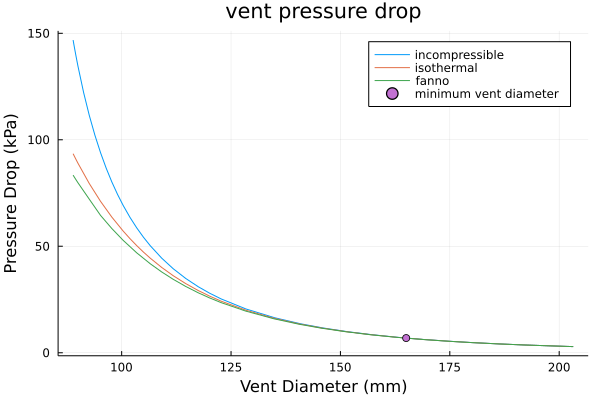

In [14]:
#| echo: false
#| label: fig-4
#| fig-cap: "Pressure drop versus vent diameter for the three models explored."
let

pᵢₙ(D) = find_zero( p₁ -> p₁ - pₐ - 0.5*ΣK(ϵ/D,L/D,Re(D,Tₐ))*ρ((p₁ + pₐ)/2, Tₐ)*v(D)^2, pₐ)

Dₗ, Dᵤ = ustrip(u"mm", 3.5inch), ustrip(u"mm", 8inch)

incompressible(D) = ustrip(u"kPa", pᵢₙ(D*0.001u"m") - pₐ)
isothermal(D) = ustrip(u"kPa", pᵢₜ( G(D*0.001u"m"), ϵ/(D*0.001u"m"), L/(D*0.001u"m"), Re(D*0.001u"m", Tₐ)) - pₐ)
fanno(D) = ustrip(u"kPa", pfa(D*0.001u"m") - pₐ)

plot(title = "vent pressure drop", xlabel = "Vent Diameter (mm)", ylabel="Pressure Drop (kPa)", leg=:topright)
plot!(incompressible, Dₗ, Dᵤ, lab = "incompressible")
plot!(isothermal, Dₗ, Dᵤ, lab = "isothermal")
plot!(fanno, Dₗ, Dᵤ, lab = "fanno")
plot!(ustrip.(u"mm",[D0]), ustrip.(u"kPa",[pₘₐₓ - pₐ]), seriestype = :scatter, lab="minimum vent diameter")

end

## Concluding Remarks

Often things like compressible flow can be intimidating since these problems, even in the simplified ideal gas case, require iterative solutions and often iterative solutions within iterative solutions. However, once the basic pieces are set up, compressible flow can be fairly simple to deal with. There are some pitfalls here that, if one wanted to create a nice generalized set of code, would have to be dealt with.

The big one being all the `find_zero()` calls that rely on the initial guess being a good one, or the bracketed values actually bracketing the answer. It's more than possible to supply a terrible initial guess, especially for pipe diameter, and have the root solver fail outright. Adding some code to check that guesses are within the domains of functions would be a start, e.g. catching attempts to take `log(0)` and returning `-Inf` or something to ensure that the root-finding algorithms respect function domains. This also presents an opportunity to generate better default values, programmatically, prior to solving. As opposed to me just picking reasonable numbers off the top of my head and having everything work out because I'm lucky.

Relatedly there is a lot of room to fiddle around with which root finding algorithm is employed.

## References
::: {#refs}
:::